This is the test code for active inference agent in the CARLA simulator. Different models with different number of the future image was tested which you can see in the comment

In [1]:
import carla 
import math 
import random 
import time 
import numpy as np
import csv
import cv2
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import array_to_img

2025-10-18 12:21:17.253176: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-18 12:21:17.284230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-18 12:21:17.284261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-18 12:21:17.284959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-18 12:21:17.289658: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import os

# Set the environment variable to specify which GPU to use
# For example, to use the GPU with index 0:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
saved_model_path_vae = 'Active_inference_trained_model.h5' ### 4diff on lambda
loaded_model_VAE = tf.keras.models.load_model(saved_model_path_vae)

2025-10-18 12:21:18.848010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-18 12:21:18.888633: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# Connect the client and set up bp library and spawn points
client = carla.Client('localhost', 2000) 
world = client.get_world()
bp_lib = world.get_blueprint_library()  
spawn_points = world.get_map().get_spawn_points() 
print(spawn_points)

[<carla.libcarla.Transform object at 0x7ff3bf9151c0>, <carla.libcarla.Transform object at 0x7ff3b804cdc0>, <carla.libcarla.Transform object at 0x7ff3b804cac0>, <carla.libcarla.Transform object at 0x7ff3b804d040>, <carla.libcarla.Transform object at 0x7ff3b804d140>, <carla.libcarla.Transform object at 0x7ff3b804e5c0>, <carla.libcarla.Transform object at 0x7ff3b804c1c0>, <carla.libcarla.Transform object at 0x7ff3b804df40>, <carla.libcarla.Transform object at 0x7ff3b804e140>, <carla.libcarla.Transform object at 0x7ff3b804e440>, <carla.libcarla.Transform object at 0x7ff3b804cf40>, <carla.libcarla.Transform object at 0x7ff3b804e0c0>, <carla.libcarla.Transform object at 0x7ff3b804c6c0>, <carla.libcarla.Transform object at 0x7ff3b804c340>, <carla.libcarla.Transform object at 0x7ff3b804e1c0>, <carla.libcarla.Transform object at 0x7ff3b804ebc0>, <carla.libcarla.Transform object at 0x7ff3b804eb40>, <carla.libcarla.Transform object at 0x7ff3b804cec0>, <carla.libcarla.Transform object at 0x7ff3b80

In [5]:
# Fixed time was used for Consistency and Reproducibility
settings = world.get_settings()
settings.fixed_delta_seconds = 0.01
world.apply_settings(settings)

2950

In [6]:
with open('SSIM.csv', 'w', newline='') as file_command:
    writer = csv.writer(file_command,lineterminator='\n',)
    writer.writerow(['Score'])
    file_command.close()

In [7]:
def ssim_compare(img1, img2,write) :
    dim = (160,160)

    img1 = cv2.resize(img1, dim)
    img2 = cv2.resize(img2, dim)
    img1 = img1[82:,:]
    img2 = img2[82:,:]

    ssim_score, dif = ssim(img1, img2, full=True)
    if write == True:
        with open('SSIM.csv', 'a', newline='') as file:
            writer = csv.writer(file,lineterminator='\n')
            writer.writerow([ssim_score])

    return ssim_score

In [8]:
def mse(img1, img2):

    dim = (160,160)
    img1 = cv2.resize(img1, dim)
    img2 = cv2.resize(img2, dim)
    img1 = img1[82:,:]
    img2 = img2[82:,:]
    difference = np.mean((img1 - img2) ** 2)
    return difference

In [9]:
# Add the ego vehicle
vehicle_bp = bp_lib.find('vehicle.lincoln.mkz_2020') 
vehicle = world.try_spawn_actor(vehicle_bp, spawn_points[419])

# Move the spectator behind the vehicle to view it
spectator = world.get_spectator() 
transform = carla.Transform(vehicle.get_transform().transform(carla.Location(x=-4,z=2.5)),vehicle.get_transform().rotation) 
spectator.set_transform(transform)


In [10]:
# Set initial camera translation

bound_x = 0.5 + vehicle.bounding_box.extent.x
bound_y = 0.5 + vehicle.bounding_box.extent.y
bound_z = 0.5 + vehicle.bounding_box.extent.z
camera_init_trans = carla.Transform(carla.Location(x=+0.8*bound_x, y=+0.0*bound_y, z=1.3*bound_z))

# Add one of each type of camera
camera_bp = bp_lib.find('sensor.camera.rgb') 
camera = world.spawn_actor(camera_bp, camera_init_trans, attach_to=vehicle)

sem_camera_bp = bp_lib.find('sensor.camera.semantic_segmentation') 
sem_camera = world.spawn_actor(sem_camera_bp, camera_init_trans, attach_to=vehicle)


In [11]:
# Define respective callbacks
def rgb_callback(image, data_dict):
    data_dict['rgb_image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))

def sem_callback(image, data_dict):
    image.convert(carla.ColorConverter.CityScapesPalette)
    data_dict['sem_image'] = np.reshape(np.copy(image.raw_data), (image.height, image.width, 4))


In [12]:
def plot_image(model, image,rgb_image ,steer,file_name,write):

    ## resize the input image 
    image = cv2.resize(image, (256,256))

    ## take out the road part
    road = np.zeros((256, 256))
    road[np.where(image==128)[0], np.where(image==128)[1]]=255
    plt.imshow(road)


    
    image = cv2.resize(road, (160,160))
    image1 = image
    image = np.array(image).astype("float32")/255.0


    image = np.reshape(image,(160,160,1))
    image = np.expand_dims(image, axis=0)

    X_tstr = np.array([steer])
    X_train = [image, X_tstr]

    x_encoded = model.predict(X_train)
    x_encoded = x_encoded*255.0
    x_encoded_out = np.squeeze(x_encoded,axis=0)
    pred_image = array_to_img(x_encoded_out)
    pred_image = np.array(pred_image)

    if write == True:
        cv2.imwrite(f'/home/bimi/Bimi/users/Elahe/Active_inference/carla_image/{file_name}_input.png',image1)
        cv2.imwrite(f'/home/bimi/Bimi/users/Elahe/Active_inference/carla_image/{file_name}.png',pred_image)
        cv2.imwrite(f'/home/bimi/Bimi/users/Elahe/Active_inference/carla_image/{file_name}_rgb.png',rgb_image)
    
    return pred_image

In [13]:
test_image= '2-6.png'
test_image1 = cv2.imread(test_image)
test_image1 = cv2.cvtColor(test_image1, cv2.COLOR_RGB2GRAY) 

1/1 [==============================] - 0s 34ms/step


2025-10-18 12:21:21.110607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.


1/1 [==============================] - 0s 31ms/step
Step 50: Inference time: 1333.802 ms, Selected steering: 0.10
1/1 [==============================] - 0s 32ms/step
Step 51: Inference time: 1330.748 ms, Selected steering: 0.00
1/1 [==============================] - 0s 32ms/step
Step 52: Inference time: 1336.251 ms, Selected steering: 0.00
1/1 [==============================] - 0s 31ms/step
Step 53: Inference time: 1348.657 ms, Selected steering: 0.00
1/1 [==============================] - 0s 32ms/step
Step 54: Inference time: 1343.192 ms, Selected steering: 0.00
1/1 [==============================] - 0s 31ms/step
Step 55: Inference time: 1330.344 ms, Selected steering: 0.00
1/1 [==============================] - 0s 34ms/step
Step 56: Inference time: 1374.869 ms, Selected steering: 0.00
1/1 [==============================] - 0s 31ms/step
Step 57: Inference time: 1312.347 ms, Selected steering: -0.10
1/1 [==============================] - 0s 31ms/step
Step 58: Inference time: 1344.758 m

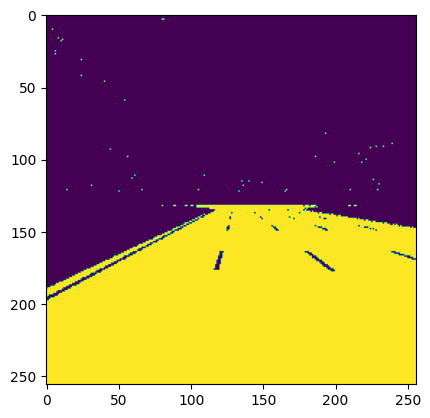

In [14]:
# Initialise parameters and data
image_w = camera_bp.get_attribute("image_size_x").as_int()
image_h = camera_bp.get_attribute("image_size_y").as_int()



sensor_data = {'rgb_image': np.zeros((image_h, image_w, 4)),
               'sem_image': np.zeros((image_h, image_w, 4))}

# OpenCV named window for display
cv2.namedWindow('All cameras', cv2.WINDOW_AUTOSIZE)

# Tile all data in one array
top_row = np.concatenate((sensor_data['rgb_image'], sensor_data['sem_image']),axis=1)#, sensor_data['inst_image']), axis=1)

# Display with imshow
cv2.imshow('All cameras',top_row)
cv2.waitKey(1)

# Set sensors recording
camera.listen(lambda image: rgb_callback(image, sensor_data))
sem_camera.listen(lambda image: sem_callback(image, sensor_data))

# Indefinite while loop
v2 = 0
t_command = 0
s_command = 0
cnt = 0
loc = []
write = False
WARMUP_STEPS = 50
BATCH_SIZE = 1000
inference_durations = []
batch_timing_buffer = []
batch_index = 0
step_index = 0
latency_csv_path = 'inference_latency_batches.csv'
with open('location_town04.csv', 'w', newline='') as file_command:
    writer = csv.writer(file_command,lineterminator='',)
    writer.writerow(['X',"Y","Z","pitch","yaw","roll","speed",'waypoint_x','waypoint_y','waypoint_z'])
    file_command.close()
with open(latency_csv_path, 'w', newline='') as timing_file:
    timing_writer = csv.writer(timing_file, lineterminator='')
    timing_writer.writerow(['batch_index', 'steps', 'mean_latency_ms', 'std_latency_ms'])

while vehicle.get_transform().location.x<spawn_points[252].location.x:

    # Tile camera images into one array
    top_row = np.concatenate((sensor_data['rgb_image'], sensor_data['sem_image']),axis=1)#, sensor_data['inst_image']), axis=1)
    position = (50, 50)  # (x, y) coordinates

    # Specify the font type
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Specify the font scale (font size)
    font_scale = 0.5

    # Specify the font color in BGR format
    font_color = (0, 0, 0)  # Blue

    # Specify the line type
    line_type = 2

    # Add the text to the image
    cv2.putText(top_row, 'velocity is: '+ str(v2) + '   throttle is: ' + str(t_command) + '     steering is '+ str(s_command), position, font, font_scale, font_color, line_type)

    cv2.imshow('All cameras',top_row)

    tick_start = time.perf_counter()
    list_image = []
    for i in range(-100,100,10):
        steer = i/100
        list_image.append(plot_image(loaded_model_VAE, sensor_data['sem_image'],sensor_data['rgb_image']  ,steer,i+100,write))
        
    ls_val = []
    for i in range(len(list_image)):
        ssim_val = ssim_compare(list_image[i],test_image1,write)
        ls_val.append(ssim_val)

    max_index = ls_val.index(max(ls_val))
    s_command = (max_index-10)/10
    tick_end = time.perf_counter()

    if step_index >= WARMUP_STEPS:
        print(f"Step {step_index}: Inference time: {(tick_end - tick_start)*1e3:.3f} ms, Selected steering: {s_command:.2f}")
        duration = tick_end - tick_start
        inference_durations.append(duration)
        batch_timing_buffer.append(duration)
        if len(batch_timing_buffer) >= BATCH_SIZE:
            batch_index += 1
            batch_array = np.array(batch_timing_buffer)
            batch_mean = batch_array.mean() * 1e3
            batch_std = (batch_array.std(ddof=1) * 1e3) if batch_array.size > 1 else 0.0
            with open(latency_csv_path, 'a', newline='') as timing_file:
                timing_writer = csv.writer(timing_file, lineterminator='')
                timing_writer.writerow([batch_index, batch_array.size, f"{batch_mean:.6f}", f"{batch_std:.6f}"])
            batch_timing_buffer.clear()
    step_index += 1

    v = vehicle.get_velocity()
    tr = vehicle.get_transform()
    v2= 3.6 * math.sqrt(v.x**2 + v.y**2 + v.z**2)

    carla_map = world.get_map()
    waypoint = carla_map.get_waypoint(tr.location, project_to_road=True, lane_type=carla.LaneType.Driving)
    loc.append([tr.location.x,tr.location.y,tr.location.z,tr.rotation.pitch,tr.rotation.yaw,tr.rotation.roll,v2,waypoint.transform.location.x,waypoint.transform.location.y,waypoint.transform.location.z])
           
    if v2<10:
        t_command=0.35
    else:
        t_command=0
    vehicle.apply_control(carla.VehicleControl(throttle=t_command, steer=s_command))

    # Break loop if user presses q
    if cv2.waitKey(1) == ord('q'):
        with open('location_town04.csv', 'a', newline='') as file:
            write = csv.writer(file)
            write.writerows(loc)
        break

# Stop sensors and destroy OpenCV window
camera.stop()
sem_camera.stop()

if batch_timing_buffer:
    batch_index += 1
    batch_array = np.array(batch_timing_buffer)
    batch_mean = batch_array.mean() * 1e3
    batch_std = (batch_array.std(ddof=1) * 1e3) if batch_array.size > 1 else 0.0
    with open(latency_csv_path, 'a', newline='') as timing_file:
        timing_writer = csv.writer(timing_file, lineterminator='')
        timing_writer.writerow([batch_index, batch_array.size, f"{batch_mean:.6f}", f"{batch_std:.6f}"])

if inference_durations:
    durations = np.array(inference_durations)
    mean_latency = durations.mean()
    std_latency = durations.std(ddof=1) if durations.size > 1 else 0.0
    steps_per_second = 1.0 / mean_latency if mean_latency > 0 else float('inf')
    print(
        f"[TIMING] Active inference forward pass: {mean_latency * 1e3:.3f} ms +/- {std_latency * 1e3:.3f} ms "
        f"over {durations.size} steps (warmup={WARMUP_STEPS}, ~{steps_per_second:.1f} steps/s)"
    )
else:
    print("[TIMING] No inference timings recorded (insufficient steps after warmup).")
